# Goal: make heat scatter plot like in LSD

<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle code on/off."></form>

In [1]:
suppressMessages({
    .libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
    # config opts and libraries
    options(repr.plot.width = 6, repr.plot.height = 5)
    options(jupyter.plot_mimetypes = 'image/png')
    devtools::source_url("https://raw.githubusercontent.com/scalefreegan/R-tools/master/defaultRlibs.R")
    devtools::source_url("https://raw.githubusercontent.com/scalefreegan/steinmetz-lab/master/yeast2_0/scripts/scrambletools.R")
    library(LSD)
    library(MASS)
    library(ggrepel)
})

In [2]:
gs_38 = read_delim("/g/steinmetz/brooks/Yeast_CRISPRi_GeneScores/GeneScore_ThirtyEight.txt", 
                col_names = T, delim = "\t")
gs_38$row = NULL
gs_23 = read_delim("/g/steinmetz/brooks/Yeast_CRISPRi_GeneScores/GeneScore_TwentyThree.txt",
                col_names = T, delim = "\t")
gs_23$row = NULL
df = merge(gs_38, gs_23, by = c("gene","ORF","identity","essential"))

Parsed with column specification:
cols(
  row = col_integer(),
  gene = col_character(),
  ORF = col_character(),
  identity = col_character(),
  sig = col_logical(),
  score = col_double(),
  essential = col_logical()
)
Parsed with column specification:
cols(
  row = col_integer(),
  gene = col_character(),
  ORF = col_character(),
  identity = col_character(),
  sig = col_logical(),
  score = col_double(),
  essential = col_logical()
)


In [10]:
# generare random data, swap this for yours :-)!
# n <- 10000
# x <- df$score.x
# y <- df$score.y
# DF <- data.frame(x,y)

# Calculate 2d density over a grid
# dens <- kde2d(x,y)
dens <- kde2d(df$score.x,df$score.y)

# create a new data frame of that 2d density grid
# (needs checking that I haven't stuffed up the order here of z?)
gr <- data.frame(with(dens, expand.grid(dens$x,dens$y)), as.vector(dens$z))
names(gr) <- c("xgr", "ygr", "zgr")

# Fit a model
mod <- loess(zgr~xgr*ygr, data=gr)

# Apply the model to the original data to estimate density at that point
# DF$pointdens <- predict(mod, newdata=data.frame(xgr=x, ygr=y))
df$pointdens <- predict(mod, newdata=data.frame(xgr=df$score.x, ygr=df$score.y))

In [49]:
# Draw plot
lm_eqn <- function(x, y, intercept = F){
    if (intercept) {
        m <- lm(y ~ x)
        eq <- substitute(italic(y) == a + b %.% italic(x)*","~~italic(r)^2~"="~r2, 
             list(a = format(coef(m)[1], digits = 2), 
                  b = format(coef(m)[2], digits = 2), 
                 r2 = format(summary(m)$r.squared, digits = 3)))
    } else {
        m <- lm(y ~ 0+ x)
        eq <- substitute(italic(y) == a %.% italic(x)*","~~italic(r)^2~"="~r2, 
             list(a = format(coef(m)[1], digits = 2),  
                 r2 = format(summary(m)$r.squared, digits = 3)))
    }
   return(as.character(as.expression(eq)))   
}

p <- ggplot() + geom_point(data = df, aes(x=score.x,y=score.y, color=pointdens)) + 
    ylim(c(-3,3)) + xlim(c(-3,3)) + 
    geom_smooth(data = df, aes(x=score.x,y=score.y), method = "lm", se = FALSE, color = "black") +
    geom_text(data = df, x = 0, y = 2.8, label = lm_eqn(df$score.x, df$score.y), parse = TRUE, size = 6) + 
    geom_label_repel(data = df %>% filter(score.y < -2),
        aes(score.x, score.y, fill = identity, label = gene),
        fontface = 'bold', color = 'white',
        box.padding = unit(0.35, "lines"),
        point.padding = unit(0.5, "lines"),
        segment.color = 'grey50'
      ) +
    scale_colour_gradientn(colours = LSD::colorpalette("heat",10)) + 
    #scale_fill_gradientn(colours = LSD::colorpalette("heat",5)) +
    theme_bw()

Warning message:
: Removed 2 rows containing non-finite values (stat_smooth).Warning message:
: Removed 2 rows containing missing values (geom_point).Warning message:
: Removed 1 rows containing missing values (geom_label_repel).

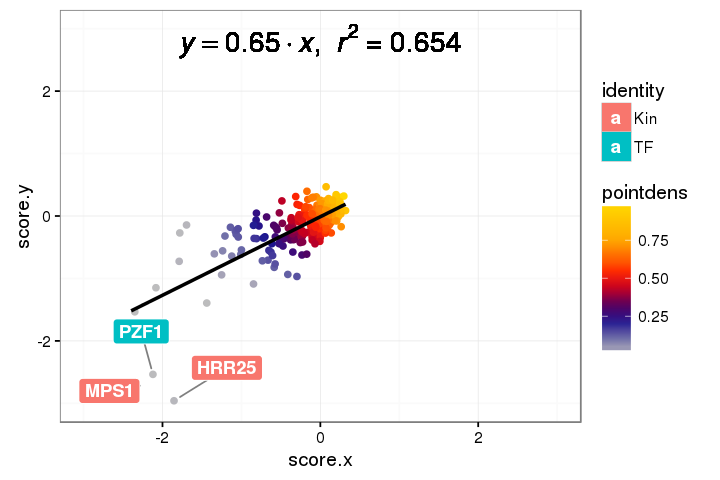

In [50]:
options(repr.plot.width = 6, repr.plot.height = 4)
p